# Time Series Prediction with Convolutional Neural Networks ($CNN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-07 19:42:54

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gathering Dependencies

_Importing Required Libraries_

In [2]:
pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import array

## Loading Datasets

_EL NINO_

In [25]:
data = pd.read_csv("/content/drive/MyDrive/new/datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


## Preprocessing the Data

In [26]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[23.4 23.4 24.2] 24.4
[23.4 24.2 24.4] 25.1
[24.2 24.4 25.1] 25.8
[24.4 25.1 25.8] 25.9
[25.1 25.8 25.9] 26.1
[25.8 25.9 26.1] 26.1
[25.9 26.1 26.1] 26.7
[26.1 26.1 26.7] 26.1
[26.1 26.7 26.1] 26.1
[26.7 26.1 26.1] 25.7
[26.1 26.1 25.7] 25.6
[26.1 25.7 25.6] 25.1
[25.7 25.6 25.1] 25.3
[25.6 25.1 25.3] 25.1
[25.1 25.3 25.1] 24.6
[25.3 25.1 24.6] 24.2
[25.1 24.6 24.2] 24.3
[24.6 24.2 24.3] 23.7
[24.2 24.3 23.7] 23.4
[24.3 23.7 23.4] 23.2
[23.7 23.4 23.2] 22.8
[23.4 23.2 22.8] 22.5
[23.2 22.8 22.5] 22.1
[22.8 22.5 22.1] 21.7
[22.5 22.1 21.7] 21.3
[22.1 21.7 21.3] 21.0
[21.7 21.3 21. ] 20.2
[21.3 21.  20.2] 20.6
[21.  20.2 20.6] 20.4
[20.2 20.6 20.4] 20.4
[20.6 20.4 20.4] 19.8
[20.4 20.4 19.8] 20.2
[20.4 19.8 20.2] 19.7
[19.8 20.2 19.7] 20.1
[20.2 19.7 20.1] 20.3
[19.7 20.1 20.3] 20.3
[20.1 20.3 20.3] 20.8
[20.3 20.3 20.8] 20.1
[20.3 20.8 20.1] 20.3
[20.8 20.1 20.3] 20.1
[20.1 20.3 20.1] 20.2
[20.3 20.1 20.2] 20.5
[20.1 20.2 20.5] 20.8
[20.2 20.5 20.8] 20.9
[20.5 20.8 20.9] 21.5
[20.8 20.9

## Train and Test Split

In [27]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1304, 1, 3) (1304,) (327, 1, 3) (327,)


## Model ($CNN$)

In [28]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle=False)

Epoch 1/500
21/21 [==============================] - 3s 22ms/step - loss: 408.4400 - val_loss: 200.5846
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 56.0689 - val_loss: 8.0995
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 5.6462 - val_loss: 1.0105
Epoch 4/500
21/21 [==============================] - 0s 8ms/step - loss: 1.2453 - val_loss: 0.9163
Epoch 5/500
21/21 [==============================] - 0s 5ms/step - loss: 0.8816 - val_loss: 0.9247
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 0.8483 - val_loss: 0.9076
Epoch 7/500
21/21 [==============================] - 0s 4ms/step - loss: 0.8408 - val_loss: 0.9060
Epoch 8/500
21/21 [==============================] - 0s 5ms/step - loss: 0.8363 - val_loss: 0.9005
Epoch 9/500
21/21 [==============================] - 0s 4ms/step - loss: 0.8319 - val_loss: 0.8958
Epoch 10/500
21/21 [==============================] - 0s 5ms/step - loss: 0.8274 - val_loss: 0.8912
Epo

## Metrics ($CNN$)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX, verbose=0)
rmse = np.sqrt(mean_squared_error(testY, yhat))
mae = np.sqrt(mean_absolute_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.858
Test MAE: 0.845


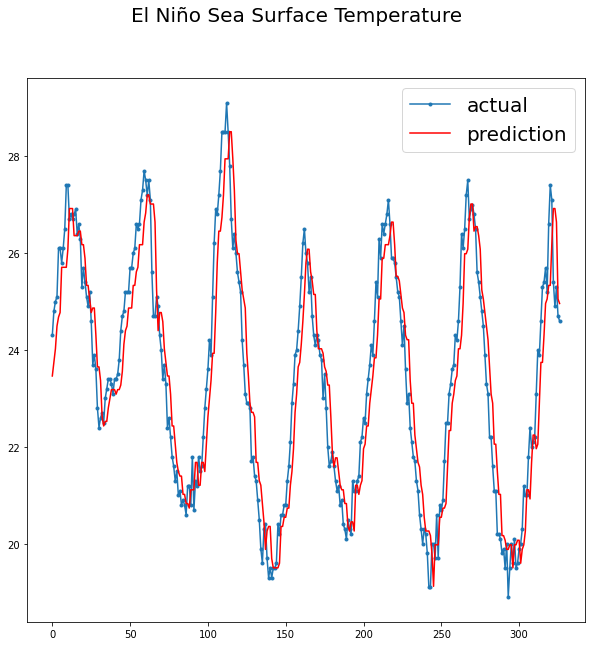

In [30]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
anurag=[x for x in range(327)]
plt.plot(anurag, testY[:327], marker='.', label="actual")
plt.plot(anurag, yhat[:327], 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()